In [9]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq
)
from nltk.tokenize import word_tokenize
import numpy as np
import gc
from sklearn.calibration import CalibratedClassifierCV
import tools
from const import (
    LEN,
    QUESTION,
    DATASET_NAME,
    FORMAT,
    FORMAT_GOOGLE,
    ZERO_TOKEN,
    ONE_TOKEN,
    MAX_INPUT_LENGTH,
    SEED
)

In [10]:
LANGUAGES = ["ru"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PER_DEVICE_EVAL_BATCH_SIZE = 85

In [11]:
tools.set_seed(SEED)

In [4]:
seahorse = load_dataset(DATASET_NAME)

def filter_data(example): 
    if(example[QUESTION] == 0.5):
        return False

    example[QUESTION] = int(example[QUESTION])
    return example['lang'] in LANGUAGES and len(example['summary']) > LEN and len([token for token in word_tokenize(example['summary'], language='russian') if token.isalpha()]) >= 0

seahorse_filtered = seahorse.filter(filter_data)
seahorse_filtered

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'lang', 'text', 'summary', 'model', 'comprehensible', 'repetition', 'grammar', 'attribution', 'main_ideas', 'conciseness'],
        num_rows: 8502
    })
    validation: Dataset({
        features: ['gem_id', 'lang', 'text', 'summary', 'model', 'comprehensible', 'repetition', 'grammar', 'attribution', 'main_ideas', 'conciseness'],
        num_rows: 1272
    })
    test: Dataset({
        features: ['gem_id', 'lang', 'text', 'summary', 'model', 'comprehensible', 'repetition', 'grammar', 'attribution', 'main_ideas', 'conciseness'],
        num_rows: 2589
    })
})

In [12]:
MODELS = [
    ("google/seahorse-large-q6", FORMAT_GOOGLE),
    ("seahorse_q6_ru_ruts_metric_large_3", FORMAT),
    ("seahorse_metric", FORMAT),
    ("seahorse_final", FORMAT),
    ("seahorse_finalll", FORMAT),
]
results = {}

In [ ]:
for model_name, model_format in MODELS:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()

    zero_token_id = tokenizer(ZERO_TOKEN).input_ids[0]
    one_token_id = tokenizer(ONE_TOKEN).input_ids[0]

    def filter_long_examples(example):
        inputs = model_format.format(example['text'], example['summary'])
        tokenized = tokenizer(inputs, truncation=False)
        return len(tokenized['input_ids']) <= MAX_INPUT_LENGTH
    validation_data_filtered_by_len = seahorse_filtered['validation'].filter(filter_long_examples, num_proc=4)
    
    def preprocess_function(examples):
        inputs = [model_format.format(article, summary)
                for article, summary in zip(examples['text'], examples['summary'])]
        model_inputs = tokenizer(
            inputs,
            max_length=MAX_INPUT_LENGTH,
            truncation=True,
            padding=False, # Defer padding to DataCollator
        )
        model_inputs["labels"] = [[i] for i in examples[QUESTION]]
        return model_inputs
    validation_tokenized = validation_data_filtered_by_len.map(preprocess_function, batched=True, num_proc=4, remove_columns=validation_data_filtered_by_len.column_names)

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

    val_data_loader = torch.utils.data.DataLoader(validation_tokenized, batch_size=PER_DEVICE_EVAL_BATCH_SIZE, collate_fn=data_collator, shuffle=False)

    val_logits_target, val_labels_binary = tools.get_logits_and_labels(
        model, val_data_loader, zero_token_id, one_token_id, DEVICE
    )
    optimal_threshold = tools.find_best_threshold(val_logits_target, val_labels_binary)

    final_results = tools.calculate_final_metrics(
        val_logits_target, val_labels_binary, optimal_threshold
    )

    results[model_name] = final_results

    val_scores_diff = val_logits_target[:, 1] - val_logits_target[:, 0]

    X_dummy = np.arange(len(val_labels_binary)).reshape(-1, 1) # Просто фиктивные данные для X
    diff_classifier = tools.DifferenceAsProbabilityClassifier(val_scores_diff)
    calibrated_model_cv = CalibratedClassifierCV(
        estimator=diff_classifier, # Используем наш фиктивный классификатор
        method='isotonic',        # Или 'sigmoid'
        cv=5                      # Количество фолдов для кросс-валидации на валидационном наборе
    )
    calibrated_model_cv.fit(X_dummy, val_labels_binary)

    calibrated_probabilities_val = calibrated_model_cv.predict_proba(X_dummy)[:, 1]
    optimal_calibrated_threshold = tools.find_best_threshold_from_probabilities(calibrated_probabilities_val, val_labels_binary)
    calibrated_final_results = tools.calculate_calibrated_metrics(
             val_logits_target,
             val_labels_binary,
             optimal_calibrated_threshold,
             calibrated_probabilities_val
    )

    results[model_name]['calibrated_f1'] = calibrated_final_results['f1']
    results[model_name]['calibrated_accuracy'] = calibrated_final_results['accuracy']
    results[model_name]['calibrated_mean_confidence_overall'] = calibrated_final_results['mean_confidence_overall']
    results[model_name]['calibrated_mean_confidence_correct'] = calibrated_final_results['mean_confidence_correct']
    results[model_name]['calibrated_mean_confidence_incorrect'] = calibrated_final_results['mean_confidence_incorrect']
    results[model_name]['calibrated_ece'] = calibrated_final_results['ece']
    results[model_name]['calibrated_mce'] = calibrated_final_results['mce']

    if 'model' in locals() and model is not None:
        del model
    if 'tokenizer' in locals() and tokenizer is not None:
        del tokenizer
    if 'data_collator' in locals() and data_collator is not None:
            del data_collator
    if 'val_data_loader' in locals() and val_data_loader is not None:
            del val_data_loader
    if 'val_logits_target' in locals() and val_logits_target is not None:
            del val_logits_target
    if 'val_labels_binary' in locals() and val_labels_binary is not None:
            del val_labels_binary
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

Filter (num_proc=4):   0%|          | 0/1272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1222 [00:00<?, ? examples/s]

Evaluating and collecting logits:   0%|          | 0/15 [00:00<?, ?it/s]

Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.4500 (max F1 = 0.7410)


Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.4500 (max F1 = 0.7410)


Filter (num_proc=4):   0%|          | 0/1272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1267 [00:00<?, ? examples/s]

Evaluating and collecting logits:   0%|          | 0/15 [00:00<?, ?it/s]

Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.6100 (max F1 = 0.7326)


Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.5200 (max F1 = 0.7340)


Filter (num_proc=4):   0%|          | 0/1272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1267 [00:00<?, ? examples/s]

Evaluating and collecting logits:   0%|          | 0/15 [00:00<?, ?it/s]

Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.6100 (max F1 = 0.7326)


Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.5200 (max F1 = 0.7340)


Filter (num_proc=4):   0%|          | 0/1272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1267 [00:00<?, ? examples/s]

Evaluating and collecting logits:   0%|          | 0/15 [00:00<?, ?it/s]

Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.4800 (max F1 = 0.7329)


Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.4300 (max F1 = 0.7344)


Filter (num_proc=4):   0%|          | 0/1272 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1267 [00:00<?, ? examples/s]

Evaluating and collecting logits:   0%|          | 0/15 [00:00<?, ?it/s]

Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.5900 (max F1 = 0.7341)


Finding best threshold:   0%|          | 0/101 [00:00<?, ?it/s]


Optimal threshold found: 0.5700 (max F1 = 0.7358)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

metric_names = [
    "pearson_corr", "roc_auc", "accuracy", "f1",
    "mean_confidence_overall", "mean_confidence_correct", "mean_confidence_incorrect", "ece", "mce",
    "calibrated_accuracy", "calibrated_f1",
    "calibrated_mean_confidence_overall", "calibrated_mean_confidence_correct", "calibrated_mean_confidence_incorrect", "calibrated_ece", "calibrated_mce"
]

def plot_metrics(rslts):
    for metric in metric_names:
        values = [rslts[model][metric] for model in rslts]
        plt.figure(figsize=(10, 5))
        bars = plt.bar(rslts.keys(), values, color='skyblue')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., 
                    height * 0.5,
                    f'{height:.3f}',
                    ha='center', 
                    va='center', 
                    color='black', 
                    fontweight='bold')
        
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric}")
        plt.xticks(rotation=15, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    models = list(rslts.keys())
    correct_confidences = [rslts[m]["mean_confidence_correct"] for m in models]
    incorrect_confidences = [rslts[m]["mean_confidence_incorrect"] for m in models]
    x = np.arange(len(models))
    width = 0.35
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x - width/2, correct_confidences, width, label='Correct', color='green')
    bars2 = plt.bar(x + width/2, incorrect_confidences, width, label='Incorrect', color='red')

    for bars, color in [(bars1, 'white'), (bars2, 'white')]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., 
                    height * 0.4,
                    f'{height:.3f}',
                    ha='center', 
                    va='center',
                    color=color,
                    fontweight='bold')

    plt.xticks(x, models, rotation=15, ha='right')
    plt.ylabel("Mean Confidence")
    plt.title("Mean Confidence for Correct and Incorrect Predictions")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

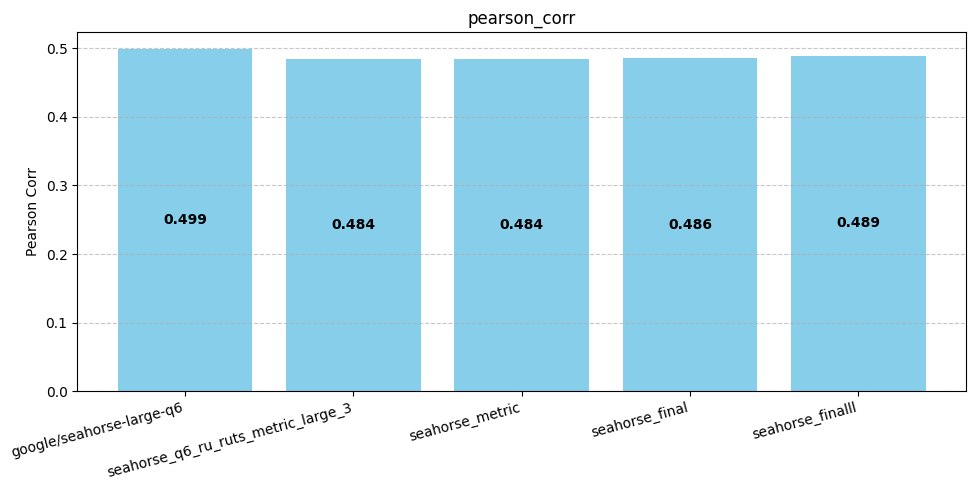

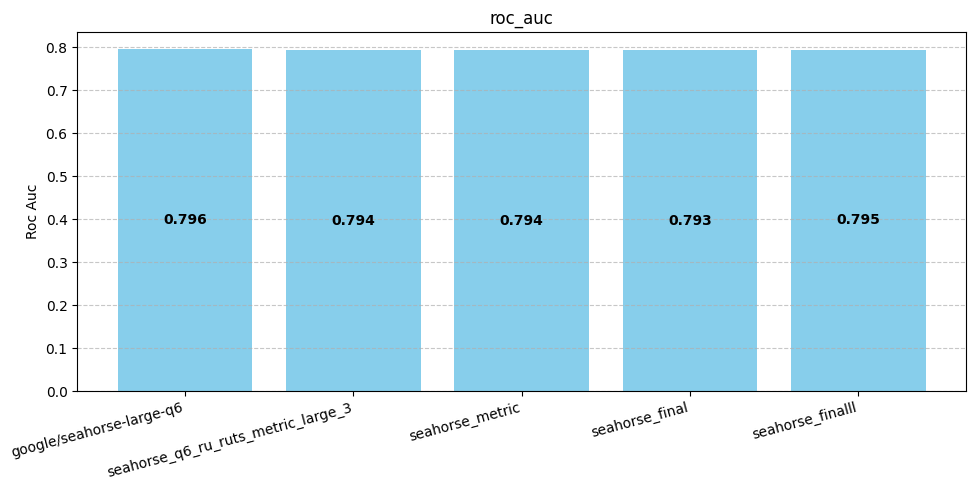

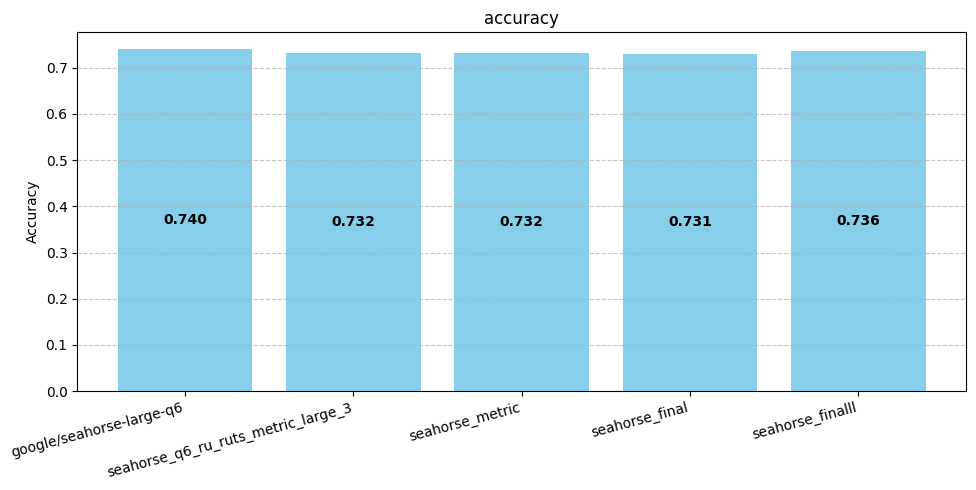

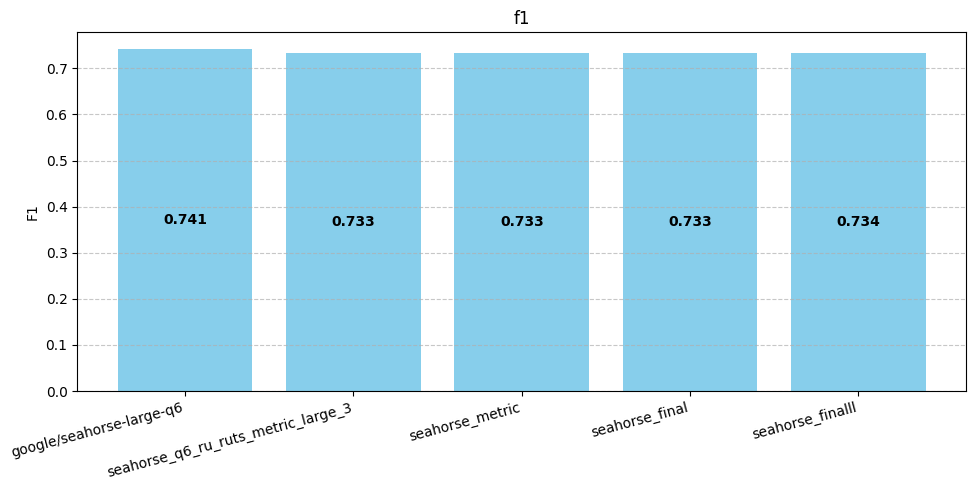

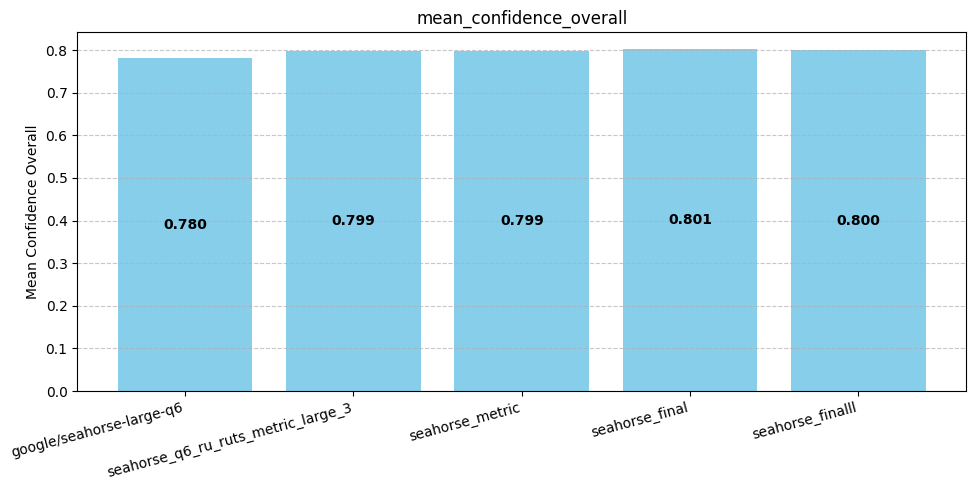

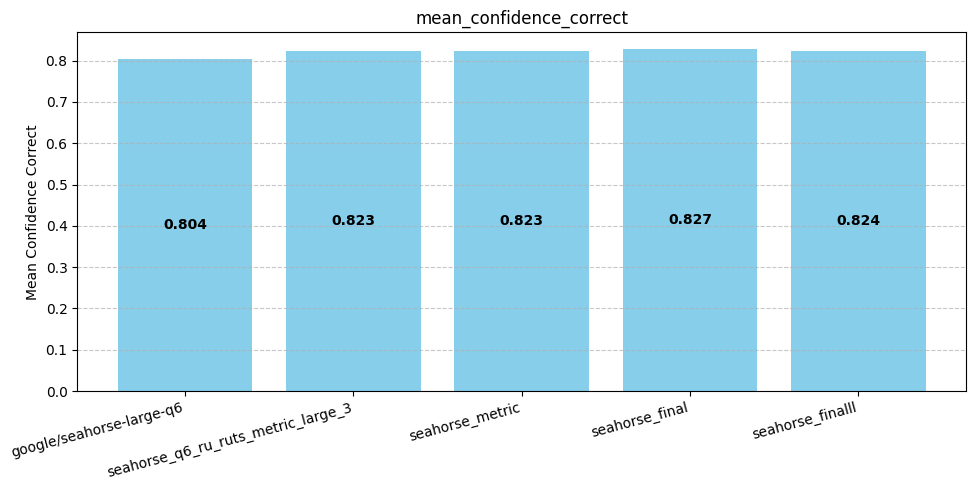

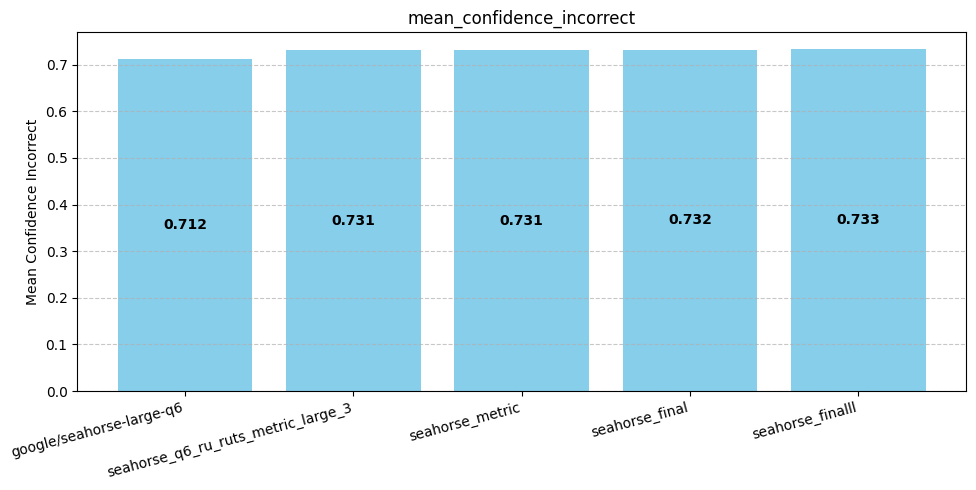

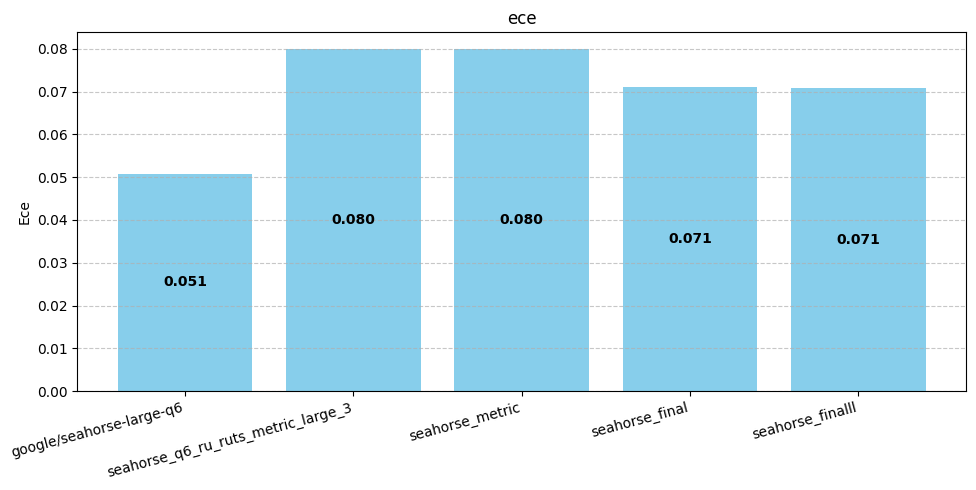

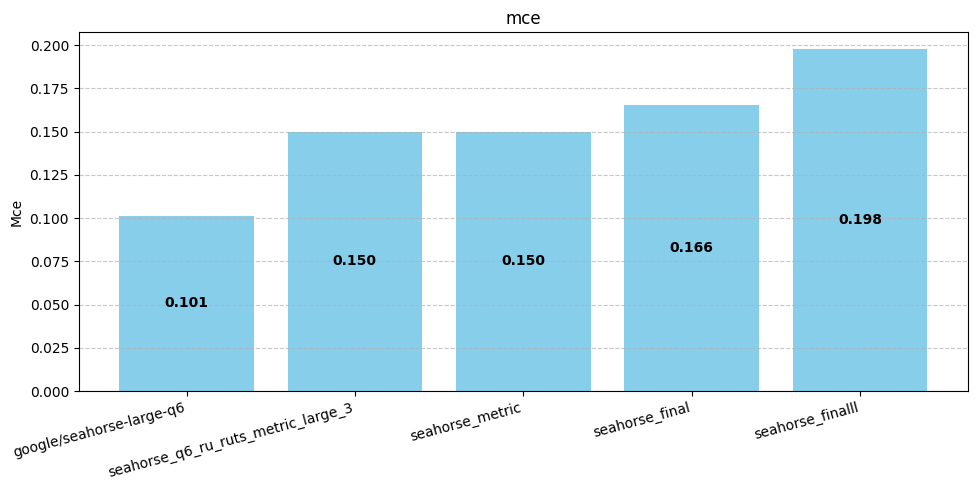

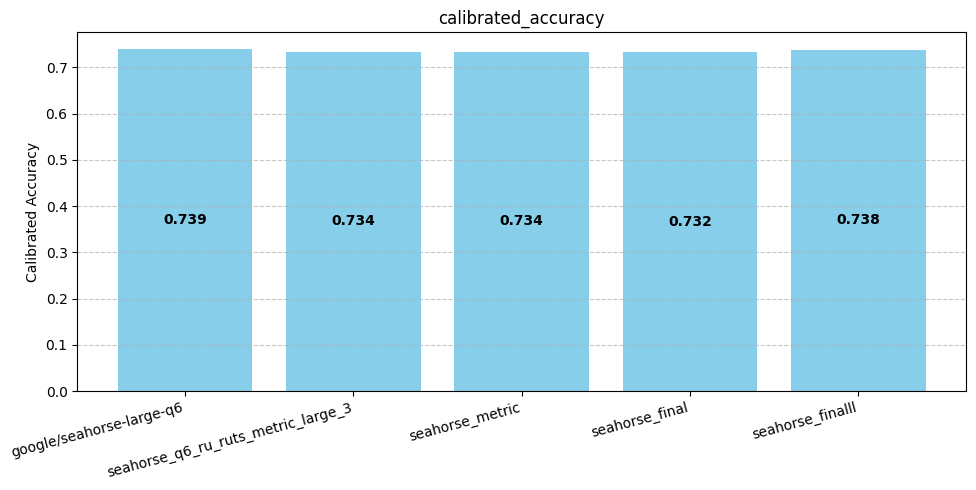

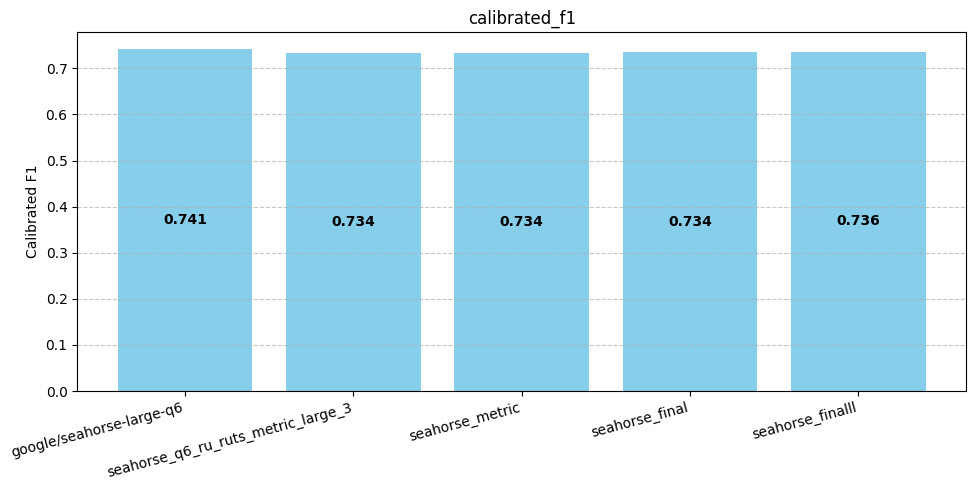

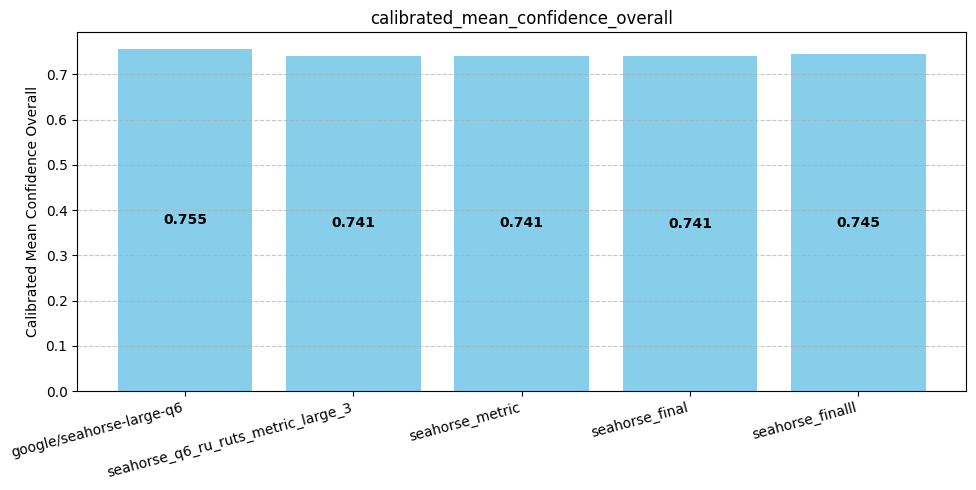

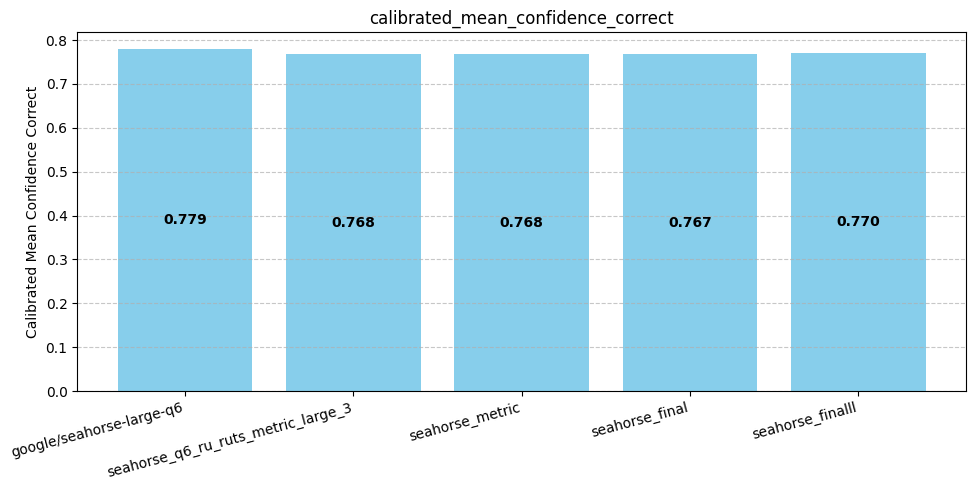

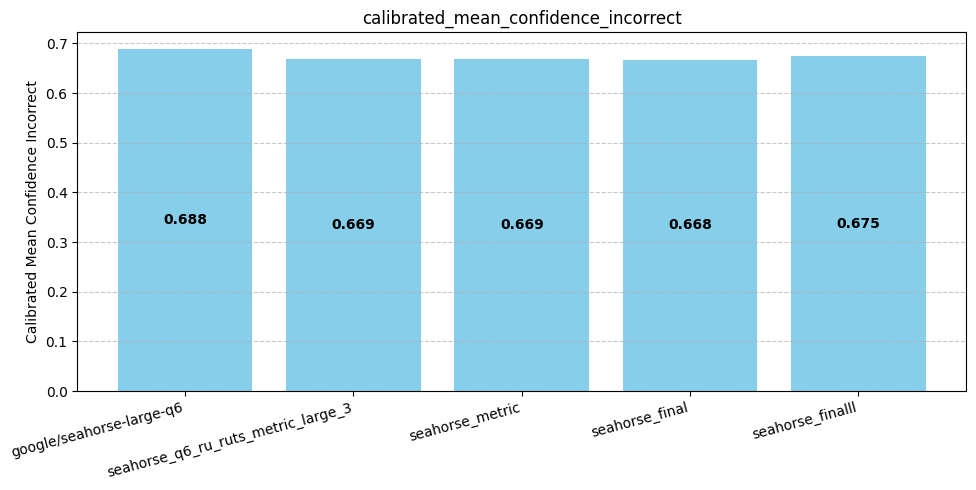

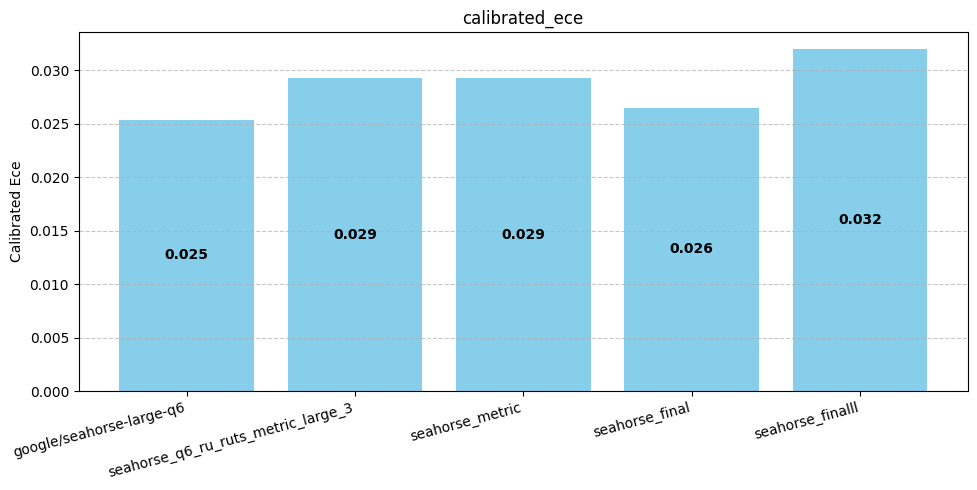

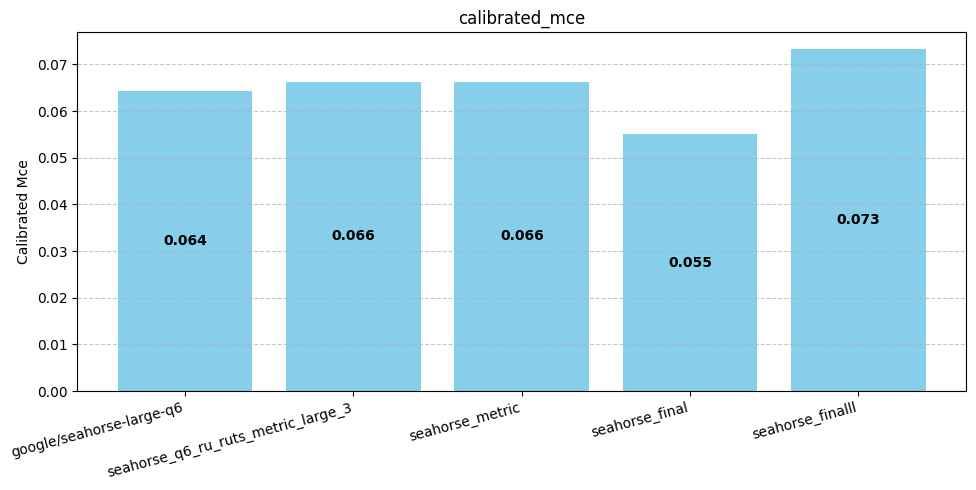

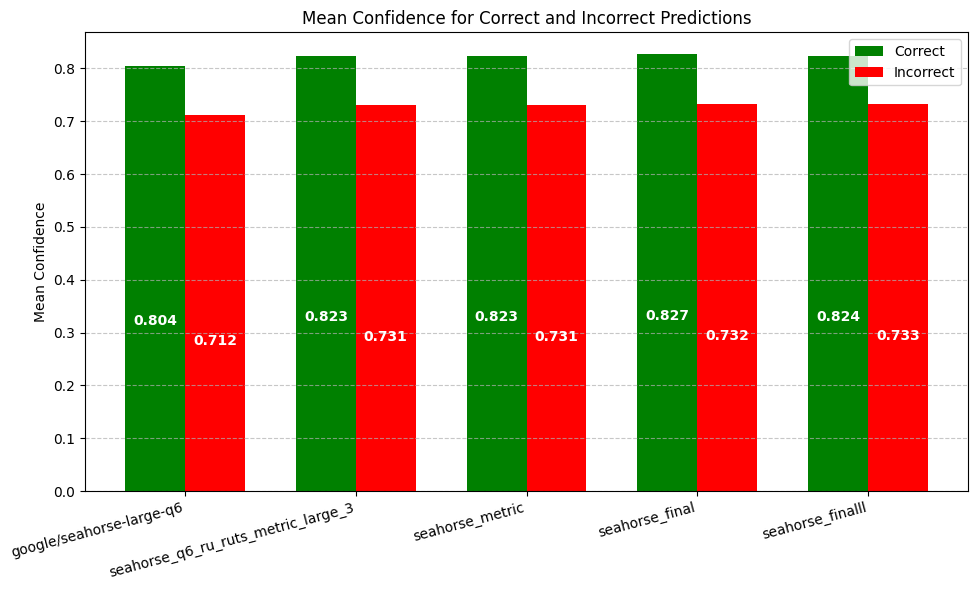

In [8]:
plot_metrics(results)

# TEST SCORING

In [18]:
from datasets import load_from_disk
from tqdm import tqdm
from collections import Counter

summ_test = load_from_disk("./filtered_test")
summ_test_results = {}

In [ ]:
for model_name, model_format in MODELS:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    model.to(DEVICE)
    model.eval()

    zero_token_id = tokenizer(ZERO_TOKEN).input_ids[0]
    one_token_id = tokenizer(ONE_TOKEN).input_ids[0]

    def filter_long_examples(example):
        inputs = model_format.format(example['text'], example['summary'])
        tokenized = tokenizer(inputs, truncation=False)
        return len(tokenized['input_ids']) <= MAX_INPUT_LENGTH
    summ_test_filtered = summ_test.filter(filter_long_examples)

    def preprocess_function(examples):
        inputs = [model_format.format(article, summary)
                for article, summary in zip(examples['text'], examples['summary'])]
        return tokenizer(
            inputs,
            max_length=MAX_INPUT_LENGTH,
            truncation=True,
            padding=False, # Defer padding to DataCollator
        )
    summ_test_tokenized = summ_test_filtered.map(preprocess_function, batched=True, num_proc=16, remove_columns=summ_test_filtered.column_names)
    
    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)
    test_data_loader = torch.utils.data.DataLoader(summ_test_tokenized, batch_size=PER_DEVICE_EVAL_BATCH_SIZE, collate_fn=data_collator, shuffle=False)

    all_logits = []

    with torch.no_grad():
        for batch in tqdm(test_data_loader, desc="Evaluating"):
            labels = batch.pop("labels")
            batch = {k: v.to("cuda") for k, v in batch.items()}

            outputs = model.generate(**batch, max_new_tokens=1, return_dict_in_generate=True, output_scores=True)
            logits = outputs["scores"][0]

            all_logits.append(logits.cpu().numpy())

            del batch, labels, outputs, logits
            gc.collect()
            torch.cuda.empty_cache()

    all_logits = np.concatenate(all_logits, axis=0)
    logit_for_0 = all_logits[:, zero_token_id]
    logit_for_1 = all_logits[:, one_token_id]
    probability_of_one = torch.sigmoid(torch.tensor(logit_for_1 - logit_for_0))
    final_score = np.mean(np.array(probability_of_one))

    pred = np.argmax(all_logits, axis=1)
    count =  Counter(pred)

    summ_test_results[model_name] = {
        "score": final_score,
        "zeros": count[zero_token_id],
        "ones": count[one_token_id],
    }

    if 'model' in locals() and model is not None:
        del model
    if 'tokenizer' in locals() and tokenizer is not None:
        del tokenizer
    if 'test_data_loader' in locals() and test_data_loader is not None:
            del test_data_loader
    if 'all_logits' in locals() and all_logits is not None:
            del all_logits
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

Evaluating: 100%|██████████| 3/3 [00:22<00:00,  7.56s/it]


In [34]:
import matplotlib.pyplot as plt
import numpy as np

metric_names = [
    "score"
]

def plot_metrics(rslts):
    for metric in metric_names:
        values = [rslts[model][metric] for model in rslts]
        plt.figure(figsize=(10, 5))
        bars = plt.bar(rslts.keys(), values, color='skyblue')
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., 
                    height * 0.5,
                    f'{height:.3f}',
                    ha='center', 
                    va='center', 
                    color='black', 
                    fontweight='bold')
        
        plt.ylabel(metric.replace("_", " ").title())
        plt.title(f"{metric}")
        plt.xticks(rotation=15, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    models = list(rslts.keys())
    correct_confidences = [rslts[m]["zeros"] for m in models]
    incorrect_confidences = [rslts[m]["ones"] for m in models]
    x = np.arange(len(models))
    width = 0.35
    plt.figure(figsize=(10, 6))
    bars1 = plt.bar(x - width/2, correct_confidences, width, label='Correct', color='green')
    bars2 = plt.bar(x + width/2, incorrect_confidences, width, label='Incorrect', color='red')

    for bars, color in [(bars1, 'white'), (bars2, 'white')]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., 
                    height * 0.4,
                    f'{height}',
                    ha='center', 
                    va='center',
                    color=color,
                    fontweight='bold')

    plt.xticks(x, models, rotation=15, ha='right')
    plt.ylabel("Mean Confidence")
    plt.title("Mean Confidence for Correct and Incorrect Predictions")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

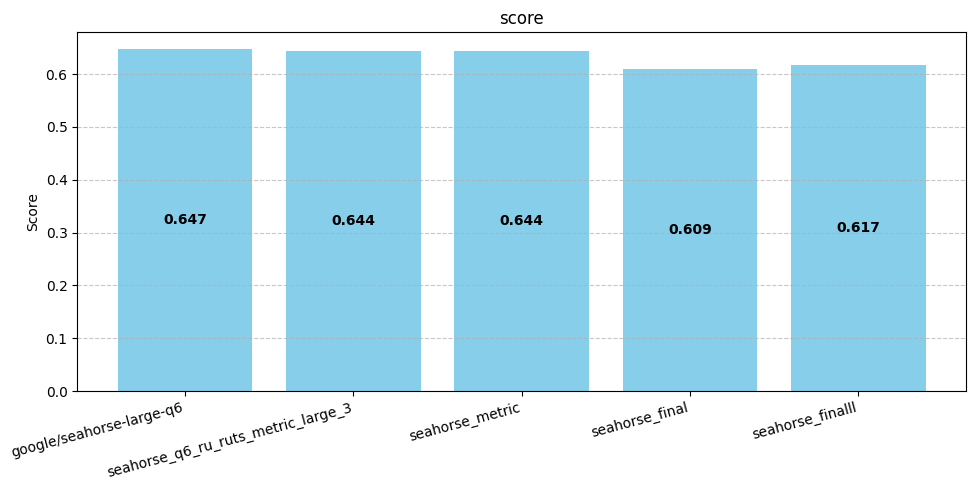

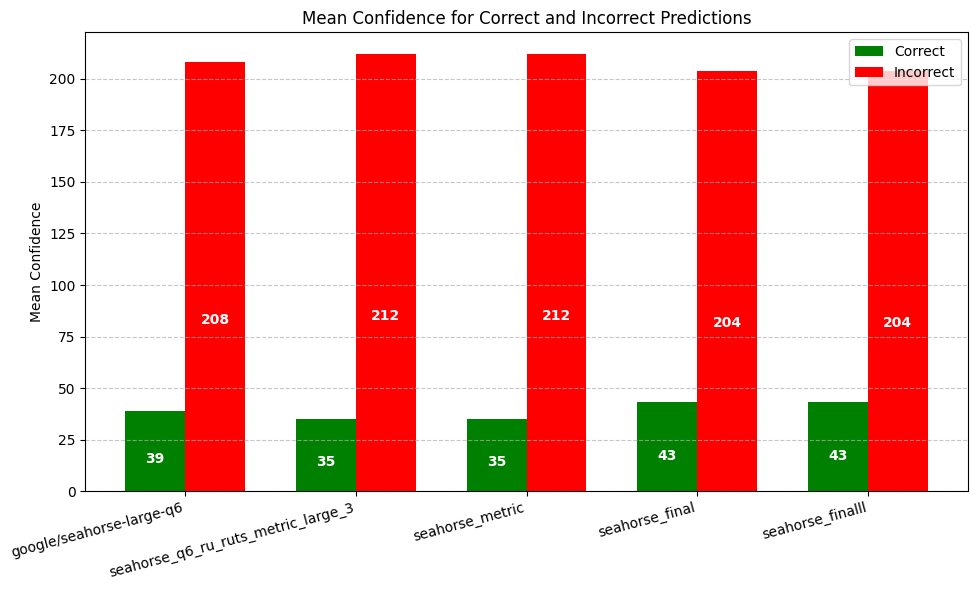

In [35]:
plot_metrics(summ_test_results)